### Interactive notebook to demo the interactive PPCA model

In [142]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
# from scipy.stats import invgamma, lognorm
from matplotlib import pyplot as plt
from matplotlib import collections  as mc

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

from IPython.display import display, clear_output
from ipywidgets import Output, Label, VBox, HBox, Button
from ipywidgets import interact

from bqplot import (
    Axis, ColorAxis, LinearScale, LogScale, DateColorScale, OrdinalScale,
    OrdinalColorScale, ColorScale, Scatter, Lines, Figure, Tooltip
)

from ppca_model import MAP
from common.dataset import dataset
import common.plot.simple_plot
from common.plot.simple_plot import SimpleFigure
from common.plot.scatter import imscatter, ellipse_scatter
from common.metric.dr_metrics import DRMetric

dataset.set_data_home('./data')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
X_original, X, y = dataset.load_dataset('FASHION100')
X = torch.tensor(X, dtype=torch.float)
losses, z2d_loc, z2d_scale = MAP(X, learning_rate=0.2, n_iters=250)

/home/vmvu/WorkspaceSync/ppca-uncertainty/ppca_model.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float)
100%|██████████| 250/250 [00:01<00:00, 143.85it/s]

q_sigma torch.Size([1, 784])
q_alpha torch.Size([2, 1])
q_W torch.Size([2, 784])
qZ_loc torch.Size([200])
qZ_scale torch.Size([200])


In [50]:
errors = np.linalg.norm(z2d_scale, axis=1)

K = 10
top_K_ind = np.argpartition(errors, -K)[-K:]

In [51]:
# linear interpolate error range to bubble size
errors_as_size = np.interp(errors,
                           [np.min(errors), np.max(errors)],
                           [32, 512])

def log_interp1d(xx, yy, kind='linear'):
    '''https://stackoverflow.com/questions/29346292/logarithmic-interpolation-in-python'''
    import scipy as sp
    import scipy.interpolate
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

# interpolate errors in log scale
errors_as_size = log_interp1d(
    [np.min(errors), np.max(errors)],
    [32, 512]
)(errors)

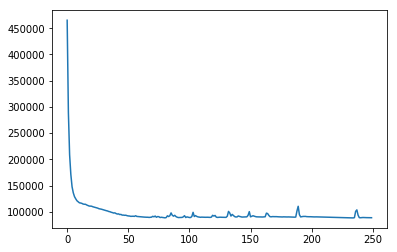

In [40]:
plt.plot(losses)

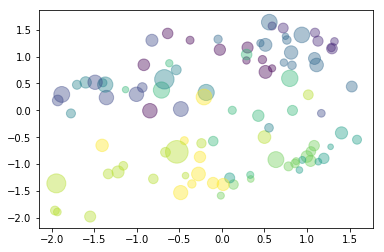

In [52]:
plt.scatter(
    x=z2d_loc[:, 0],
    y=z2d_loc[:, 1],
    c=y,
    s=errors_as_size,
    alpha=0.4
)

In [144]:
def scatter_with_images(ax, z2d, z2d_scale, original_data, labels_true):
    ax.scatter(z2d[:, 0], z2d[:, 1])
    imscatter(ax, z2d, data=original_data, zoom=.75, inverse_cmap=True,
              custom_cmap=None, labels_true=labels_true)
    # ellipse_scatter(ax, z2d, z2d_scale, labels_true)

In [166]:
sc_x = LinearScale()
sc_y = LinearScale()
sc_c = OrdinalColorScale(colors=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf'])
sc_size = LinearScale() # LinearScale()

def_tt = Tooltip(fields=['index'], formats=[''])

scatt = Scatter(
    x=z2d_loc[:, 0],
    y=z2d_loc[:, 1],
    color=y,
    size=errors, default_size=128,
    names=np.arange(z2d_loc.shape[0]),
    display_names=False,
    default_opacities=[0.8],
    scales={'x': sc_x, 'y': sc_y, 'color': sc_c, 'size': sc_size},
    enable_move=True,
    tooltip=def_tt,
    unhovered_style={'opacity': 0.5},
)

ax_x = Axis(scale=sc_x, grid_color='#EAECEE', grid_lines='dashed')
ax_y = Axis(scale=sc_y, orientation='vertical', grid_color='#EAECEE', grid_lines='dashed')
ax_c = ColorAxis(scale=sc_c, orientation='vertical', side='right')


lbl = Label(color='green', font_size='18px', value='debug')
def drag_handler(scatter, value):
    lbl.value = str(value)

scatt.on_drag_end(drag_handler)
    
out = Output(layout={'border': '0px solid black', 'width': '600px', 'display': 'inline-block'})

_, ax = plt.subplots(1,1, figsize=(7,7))
with out:
    ax.clear()
    scatter_with_images(ax, z2d_loc, z2d_scale, X_original, y)
    clear_output(wait=True)
    plt.tight_layout()
    display(ax.figure)
    plt.close()
    
fig = Figure(marks=[scatt], axes=[ax_x, ax_y], fig_margin=dict(top=25, bottom=60, left=60, right=60))
fig.background_style = {'fill': 'White'}
fig.layout = {'width': '530px', 'height': '530px'}

btn_run = Button(
    description='Run',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)

VBox([HBox([out, fig]),
      lbl,
      btn_run
     ])